In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import nibabel as nib
from matplotlib import pyplot as plt
import pydicom

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

import os
import time
import glob
import numpy as np
from numpy import savez_compressed
from numpy import load
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

import gc
gc.collect()
torch.cuda.empty_cache()

### Preprocessing

In [2]:
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize([0.5],[0.5]),
                    transforms.Resize((256,256))
])

In [3]:
class Dataloader():
    def __init__(self, o_path, t_path):
        self.o_dataset = []
        self.t_dataset = []
        self.o_path = o_path
        self.t_path = t_path

    def preprocess(self):     
        org_patients = []
        
        # Reading and putting in Original Images
        for org_file in glob.glob(self.o_path):
            org_patient = []
            org_dcm = []
            
            org_name = org_file[31:]
            org_patients.append(org_name)
            
            for dcm_file in glob.glob(org_file + '/*'):
                dcm_base = os.path.basename(dcm_file)
                org_dcm.append(dcm_base)
            org_dcm.sort()
            
            
            for dcm_name in org_dcm:
                org_img = pydicom.dcmread(org_file + '/' + dcm_name)
                
                # convert dicom file to numpy array
                data1 = org_img.pixel_array
                data1 = data1.astype('float32')
                data1 = transform(data1)
                data1 = np.reshape(data1, (1,1,256,256))
                org_patient.append(data1)
            
            org_output = org_patient[0]

            count = 0
            for o_data in org_patient:
                if count == 0:
                    count += 1
                    continue
                org_output = torch.cat([org_output, o_data], 0)

            self.o_dataset.append(org_output)
            
        # TARGET
        for target_name in org_patients:
            tar_patient = []
            tar_dcm = []
            
            for dcm_file in glob.glob(self.t_path + target_name + '/*'):
                dcm_base = os.path.basename(dcm_file)
                tar_dcm.append(dcm_base)
            tar_dcm.sort()
            
            for dcm_name in tar_dcm:
                tar_img = pydicom.dcmread(self.t_path + target_name + '/' + dcm_name)
                
                # convert dicom file to numpy array
                data2 = tar_img.pixel_array
                data2 = data2.astype('float32')
                data2 = transform(data2)
                data2 = np.reshape(data2, (1,1,256,256))
                tar_patient.append(data2)
            
            tar_output = tar_patient[0]
            
            count = 0
            for t_data in tar_patient:
                if count == 0:
                    count += 1
                    continue
                tar_output = torch.cat([tar_output, t_data], 0)
            
            self.t_dataset.append(tar_output)
            
        final_orig = self.o_dataset[0]
        final_target = self.t_dataset[0]
        
        for i in range(1, len(self.o_dataset)):
            final_orig = torch.cat([final_orig, self.o_dataset[i]], 0)
            final_target = torch.cat([final_target, self.t_dataset[i]], 0)
            
        return final_orig, final_target

In [4]:
data = Dataloader('/home/mri-any/GAN_Data/orignal/*', '/home/mri-any/GAN_Data/target/')

orig, target = data.preprocess()
ds = TensorDataset(orig, target)
train_dataloader = DataLoader(ds, batch_size=1, shuffle=True)

### Generator Model ###

In [5]:
# UNet
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super().__init__()

        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False)]

        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels)),

        layers.append(nn.LeakyReLU(0.2))

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.down = nn.Sequential(*layers)

    def forward(self, x):
        x = self.down(x)
        return x

In [6]:
class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super().__init__()

        layers = [
            nn.ConvTranspose2d(in_channels, out_channels,4,2,1,bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU()
        ]

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.up = nn.Sequential(*layers)

    def forward(self,x,skip):
        x = self.up(x)
        x = torch.cat((x,skip),1)
        return x

In [7]:
# generator: 가짜 이미지를 생성합니다.
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64,128)                 
        self.down3 = UNetDown(128,256)               
        self.down4 = UNetDown(256,512,dropout=0.5) 
        self.down5 = UNetDown(512,512,dropout=0.5)      
        self.down6 = UNetDown(512,512,dropout=0.5)             
        self.down7 = UNetDown(512,512,dropout=0.5)              
        self.down8 = UNetDown(512,512,normalize=False,dropout=0.5)

        self.up1 = UNetUp(512,512,dropout=0.5)
        self.up2 = UNetUp(1024,512,dropout=0.5)
        self.up3 = UNetUp(1024,512,dropout=0.5)
        self.up4 = UNetUp(1024,512,dropout=0.5)
        self.up5 = UNetUp(1024,256)
        self.up6 = UNetUp(512,128)
        self.up7 = UNetUp(256,64)
        self.up8 = nn.Sequential(
            nn.ConvTranspose2d(128,1,4,stride=2,padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8,d7)
        u2 = self.up2(u1,d6)
        u3 = self.up3(u2,d5)
        u4 = self.up4(u3,d4)
        u5 = self.up5(u4,d3)
        u6 = self.up6(u5,d2)
        u7 = self.up7(u6,d1)
        u8 = self.up8(u7)

        return u8

### Discriminator Model

In [8]:
class Dis_block(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True):
        super().__init__()

        layers = [nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
    
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        x = self.block(x)
        return x

In [9]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()

        self.stage_1 = Dis_block(in_channels*2,16,normalize=False)
        self.stage_2 = Dis_block(16,32)
        self.stage_3 = Dis_block(32,64)
        self.stage_4 = Dis_block(64,128)
        self.fc1 = torch.nn.Linear(32768, 2)

    def forward(self,a,b):
        x = torch.cat((a,b),1)
        x = self.stage_1(x)
        x = self.stage_2(x)
        x = self.stage_3(x)
        x = self.stage_4(x)

        x = torch.flatten(x)
        x = self.fc1(x)

        return x

In [10]:
model_gen = GeneratorUNet().to(device)
model_dis = Discriminator().to(device)

In [11]:
# 가중치 초기화
def initialize_weights(model):
    class_name = model.__class__.__name__
    if class_name.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)

# 가중치 초기화 적용
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

In [12]:
def gradient_loss(gen_frames, gt_frames, alpha=1):

    def gradient(x):
        # idea from tf.image.image_gradients(image)
        # https://github.com/tensorflow/tensorflow/blob/r2.1/tensorflow/python/ops/image_ops_impl.py#L3441-L3512
        # x: (b,c,h,w), float32 or float64
        # dx, dy: (b,c,h,w)

        h_x = x.size()[-2]
        w_x = x.size()[-1]
        # gradient step=1
        left = x
        right = F.pad(x, [0, 1, 0, 0])[:, :, :, 1:]
        top = x
        bottom = F.pad(x, [0, 0, 0, 1])[:, :, 1:, :]

        # dx, dy = torch.abs(right - left), torch.abs(bottom - top)
        dx, dy = right - left, bottom - top 
        # dx will always have zeros in the last column, right-left
        # dy will always have zeros in the last row,    bottom-top
        dx[:, :, :, -1] = 0
        dy[:, :, -1, :] = 0

        return dx, dy

    # gradient
    gen_dx, gen_dy = gradient(gen_frames)
    gt_dx, gt_dy = gradient(gt_frames)
    #
    grad_diff_x = torch.abs(gt_dx - gen_dx)
    grad_diff_y = torch.abs(gt_dy - gen_dy)

    # condense into one tensor and avg
    return torch.mean(grad_diff_x ** alpha + grad_diff_y ** alpha)

In [13]:
def fft_loss(fake, real):
    fft_real = torch.fft.fft2(real)
    fft_fake = torch.fft.fft2(fake)
    
    fft_result = torch.pow((fft_real - fft_fake), 2)
    l2_result = torch.pow((real - fake), 2)
    
    return torch.mean((fft_result + l2_result))

In [14]:
# 손실함수
loss_func_gan = nn.BCEWithLogitsLoss()
loss_func_pix = nn.L1Loss()

# loss_func_pix 가중치
lambda_pixel = 100
lambda_gradient = 500
lambda_gen = 1

# 최적화 파라미터
from torch import optim
g_lr = 1e-4
d_lr = 1e-8
beta1 = 0.5
beta2 = 0.999

opt_dis = optim.Adam(model_dis.parameters(),lr=d_lr,betas=(beta1,beta2))
opt_gen = optim.Adam(model_gen.parameters(),lr=g_lr,betas=(beta1,beta2))

Epoch: 0, G_Loss: 579735.875000, D_Loss: 0.704862, time: 0.21 min


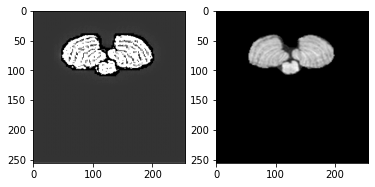

Epoch: 10, G_Loss: 27131.921875, D_Loss: 0.755208, time: 2.35 min


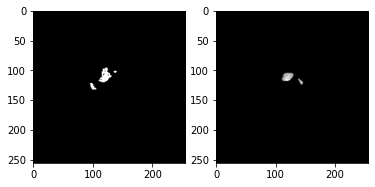

Epoch: 20, G_Loss: 3199724.750000, D_Loss: 0.526249, time: 4.50 min


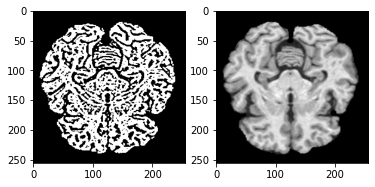

Epoch: 30, G_Loss: 2775801.500000, D_Loss: 0.520082, time: 6.64 min


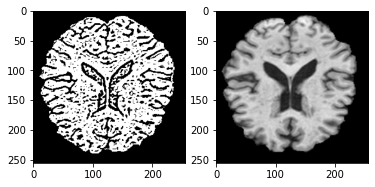

Epoch: 40, G_Loss: 2788349.000000, D_Loss: 0.446153, time: 8.79 min


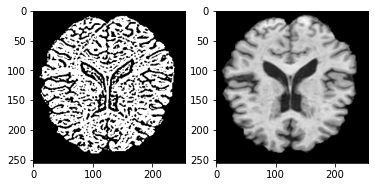

Epoch: 50, G_Loss: 2092732.000000, D_Loss: 0.305709, time: 10.93 min


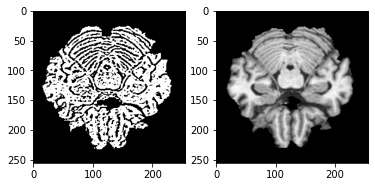

Epoch: 60, G_Loss: 633207.375000, D_Loss: 0.512064, time: 13.08 min


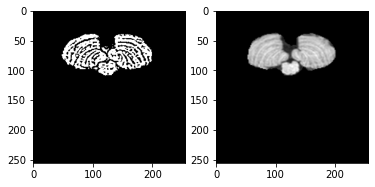

Epoch: 70, G_Loss: 1596161.000000, D_Loss: 0.418282, time: 15.23 min


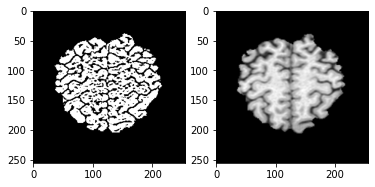

Epoch: 80, G_Loss: 2416301.500000, D_Loss: 0.205249, time: 17.37 min


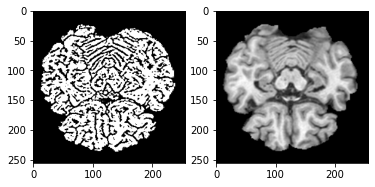

Epoch: 90, G_Loss: 751926.500000, D_Loss: 0.380280, time: 19.53 min


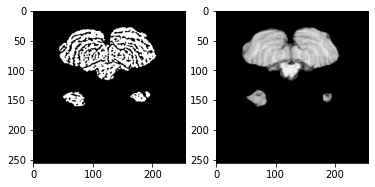

In [15]:
# 학습
model_gen.train()
model_dis.train()

batch_count = 0
num_epochs = 100
start_time = time.time()

loss_hist = {'gen':[],
             'dis':[]}

epoch_g_loss = []
epoch_d_loss = []

for epoch in range(num_epochs):
    for a, b in train_dataloader:
        ba_si = a.size(0)
        
        # real image
        real_a = a.to(device)
        real_b = b.to(device)
        
        real_label = torch.ones(2)
        fake_label = torch.zeros(2)
        real_label[1] = 0
        fake_label[1] = 1
        
        real_label, fake_label = real_label.to(device), fake_label.to(device)

        # generator
        model_gen.train()
        model_dis.eval()

        model_gen.zero_grad()

        fake_b = model_gen(real_a) # 가짜 이미지 생성
        out_dis = model_dis(fake_b, real_b) # 가짜 이미지 

        grad_loss = gradient_loss(fake_b, real_b)
        gen_loss = loss_func_gan(out_dis, real_label)
        pixel_loss = loss_func_pix(fake_b, real_b)

        g_loss = (lambda_gen * gen_loss) + (lambda_pixel * pixel_loss) + (lambda_gradient * grad_loss)
        g_loss.backward()
        opt_gen.step()

        model_dis.train()
        model_dis.zero_grad()

        out_dis = model_dis(real_b, real_a) # 진짜 이미지 식별
        real_loss = loss_func_gan(out_dis,real_label)

        out_dis = model_dis(fake_b.detach(), real_a) # 가짜 이미지 식별
        fake_loss = loss_func_gan(out_dis,fake_label)

        d_loss = (real_loss + fake_loss) / 2.
        d_loss.backward()
        opt_dis.step()
        
        epoch_g_loss.append(g_loss.item())
        epoch_d_loss.append(d_loss.item())
        
        if batch_count % 480 == 0:
            loss_hist['gen'].append(sum(epoch_g_loss)/len(epoch_g_loss))
            loss_hist['dis'].append(sum(epoch_d_loss)/len(epoch_d_loss))
            epoch_g_loss = []
            epoch_d_loss = []

        batch_count += 1
        if epoch % 10 == 0 and batch_count % 480 == 0:
            print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, g_loss.item(), d_loss.item(), (time.time()-start_time)/60))

            fake_imgs = model_gen(a.to(device)).detach().cpu()
            real_imgs = (b.to(device)).detach().cpu()
            
            real_imgs = np.squeeze(real_imgs[0])
            fake_imgs = np.squeeze(fake_imgs[0])
            
            fig = plt.figure()
            ax1 = fig.add_subplot(1,2,1)
            ax2 = fig.add_subplot(1,2,2)
            ax1.imshow(fake_imgs, cmap='gray')
            ax2.imshow(real_imgs, cmap='gray')
            plt.show()
        
        del a
        del b
        del real_label
        del fake_label

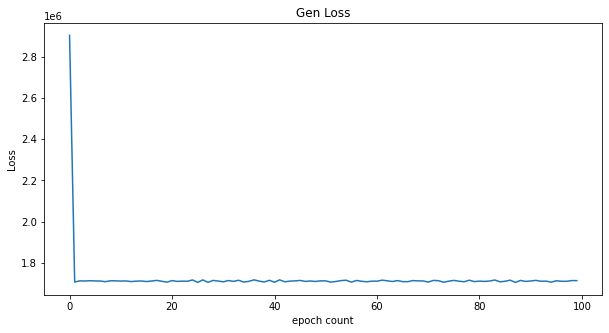

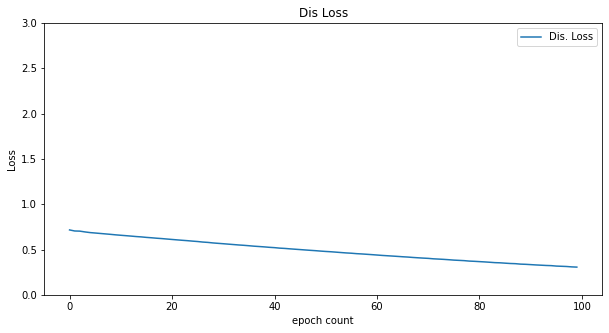

In [16]:
# loss history
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_hist['gen'], label='Gen. Loss')
plt.title('Gen Loss')
plt.xlabel('epoch count')
plt.ylabel('Loss')
plt.show()


plt.figure(figsize=(10,5))
plt.plot(loss_hist['dis'], label='Dis. Loss')
plt.title('Dis Loss')
plt.ylim(0,3)
plt.xlabel('epoch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
# 가중치 저장
path2models = '/home/mri-any/GAN_weight/'
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, 'weights_gen.pt')
path2weights_dis = os.path.join(path2models, 'weights_dis.pt')

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

In [18]:
# 가중치 불러오기
weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)

<All keys matched successfully>

In [19]:
# evaluation model
model_gen.eval()

# 가짜 이미지 생성
with torch.no_grad():
    for a,b in zip(orig, target):
        fake_imgs = model_gen(a.to(device)).detach().cpu()
        fake_imgs = np.squeeze(fake_imgs[90])
        plt.imshow(fake_imgs, cmap='gray')
        plt.figure()
        real_imgs = b
        real_imgs = np.squeeze(real_imgs[90])
        plt.imshow(real_imgs, cmap='gray')
        break

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 1, 4, 4], but got 3-dimensional input of size [1, 256, 256] instead

In [ ]:
from skimage.metrics import structural_similarity as ssim

fake_np = fake_imgs.numpy()
real_np = real_imgs.numpy()

s = ssim(fake_np, real_np)

print(s)